## Environment Setup


In [1]:
!pip install transformers datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12

## Model & Tokenizer Initialization

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# Create NER pipeline
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


## NER Inference on a Sample Sentence

In [3]:
sentence = "Elon Musk is the CEO of Tesla, founded in California."
ner_results = nlp_ner(sentence)

# Display results
for entity in ner_results:
    print(entity)

{'entity_group': 'PER', 'score': np.float32(0.71737635), 'word': 'El', 'start': 0, 'end': 2}
{'entity_group': 'PER', 'score': np.float32(0.869409), 'word': '##on Musk', 'start': 2, 'end': 9}
{'entity_group': 'ORG', 'score': np.float32(0.9944426), 'word': 'Tesla', 'start': 24, 'end': 29}
{'entity_group': 'LOC', 'score': np.float32(0.9995821), 'word': 'California', 'start': 42, 'end': 52}


## NER Visualization - HTML

In [4]:
from IPython.display import display, HTML

def visualize_ner(sentence, entities):
    html = sentence
    for ent in sorted(entities, key=lambda x: x['start'], reverse=True):
        tag = ent['entity_group']
        word = sentence[ent['start']:ent['end']]
        html = html[:ent['start']] + f"<mark style='background:lightblue; padding:2px'>{word} <sub>{tag}</sub></mark>" + html[ent['end']:]
    display(HTML(html))

visualize_ner(sentence, ner_results)


## Test on Another Sentence

In [5]:
# Sample test sentence
sentence = "Sundar Pichai is the CEO of Google, based in Mountain View."

# Use the same pipeline with the model (fine-tuned or pre-loaded)
ner_results = nlp_ner(sentence)

# Print results
for entity in ner_results:
    print(entity)


{'entity_group': 'PER', 'score': np.float32(0.9918474), 'word': 'Sundar Pichai', 'start': 0, 'end': 13}
{'entity_group': 'ORG', 'score': np.float32(0.9987941), 'word': 'Google', 'start': 28, 'end': 34}
{'entity_group': 'LOC', 'score': np.float32(0.9970554), 'word': 'Mountain View', 'start': 45, 'end': 58}


In [6]:
# Visualize
visualize_ner(sentence, ner_results)

## NER Visualization - spaCy (displacy)

In [7]:
import spacy
from spacy.tokens import Doc, Span

# Load blank spaCy model
nlp_spacy = spacy.blank("en")

def convert_to_doc(sentence, entities):
    words = sentence.split()
    doc = nlp_spacy.make_doc(sentence)
    ents = []

    for ent in entities:
        start_char = ent["start"]
        end_char = ent["end"]
        label = ent["entity_group"]
        span = doc.char_span(start_char, end_char, label=label)
        if span:
            ents.append(span)

    doc.ents = ents
    return doc

# Visualize
doc = convert_to_doc(sentence, ner_results)
spacy.displacy.render(doc, style="ent", jupyter=True)


## NER Visualization - Matplotlib


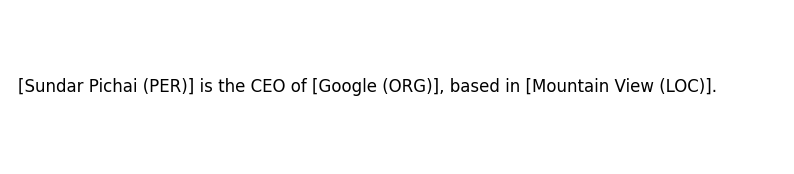

In [8]:
import matplotlib.pyplot as plt

def plot_ner_matplotlib(sentence, entities):
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis("off")
    highlighted = sentence
    for ent in sorted(entities, key=lambda x: x['start'], reverse=True):
        tag = ent['entity_group']
        word = sentence[ent['start']:ent['end']]
        highlighted = highlighted[:ent['start']] + f"[{word} ({tag})]" + highlighted[ent['end']:]
    ax.text(0.01, 0.5, highlighted, fontsize=12, va='center', wrap=True)
    plt.show()

plot_ner_matplotlib(sentence, ner_results)


## Load Dataset & Set Up Training

In [9]:
from datasets import load_dataset
from transformers import TrainingArguments, Trainer

# Load CoNLL-2003 dataset
dataset = load_dataset("conll2003")

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [10]:
# Define training arguments (compatible with older transformers versions)
training_args = TrainingArguments(
    output_dir="./results",                    # where to save model checkpoints
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",                     # where to save logs
    remove_unused_columns=False
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer
)


<ipython-input-10-22f0cb770a51>:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Update label list and tokenizer

In [11]:
from transformers import AutoTokenizer

label_list = dataset['train'].features['ner_tags'].feature.names
label_all_tokens = True  # assign label to subword tokens or not

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")


## Tokenization + label alignment function

In [12]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128,
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


##  Apply the function to the dataset

In [13]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

## Set format for PyTorch and remove unused columns

In [14]:
tokenized_dataset = tokenized_dataset.remove_columns(['id', 'tokens', 'pos_tags', 'chunk_tags'])
tokenized_dataset.set_format("torch")


In [15]:
!pip install -U transformers


##  Define Trainer and Train

In [18]:
small_train = tokenized_dataset["train"].select(range(300))
small_eval = tokenized_dataset["validation"].select(range(100))

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    logging_dir="./logs",
    save_steps=500,
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_eval,
    tokenizer=tokenizer
)


trainer.train()


<ipython-input-18-57ba474b7cac>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=19, training_loss=0.046421016517438386, metrics={'train_runtime': 406.5878, 'train_samples_per_second': 0.738, 'train_steps_per_second': 0.047, 'total_flos': 19598496998400.0, 'train_loss': 0.046421016517438386, 'epoch': 1.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.0969788059592247,
 'eval_runtime': 36.1517,
 'eval_samples_per_second': 2.766,
 'eval_steps_per_second': 0.194,
 'epoch': 1.0}

In [21]:
trainer.save_model("bert-ner-conll2003")
tokenizer.save_pretrained("bert-ner-conll2003")


('bert-ner-conll2003/tokenizer_config.json',
 'bert-ner-conll2003/special_tokens_map.json',
 'bert-ner-conll2003/vocab.txt',
 'bert-ner-conll2003/added_tokens.json',
 'bert-ner-conll2003/tokenizer.json')

In [22]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load your fine-tuned model and tokenizer
model_path = "bert-ner-conll2003"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Create a pipeline for NER using the fine-tuned model
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Test sentence
sentence = "Elon Musk is the CEO of Tesla, founded in California."

# Get NER predictions
ner_results = ner_pipeline(sentence)

# Display results
for entity in ner_results:
    print(entity)


Device set to use cpu


{'entity_group': 'MISC', 'score': np.float32(0.99851197), 'word': 'El', 'start': 0, 'end': 2}
{'entity_group': 'MISC', 'score': np.float32(0.99614817), 'word': '##on Musk', 'start': 2, 'end': 9}
{'entity_group': 'PER', 'score': np.float32(0.97908825), 'word': 'Te', 'start': 24, 'end': 26}
{'entity_group': 'PER', 'score': np.float32(0.99177307), 'word': '##sla', 'start': 26, 'end': 29}
{'entity_group': 'ORG', 'score': np.float32(0.99334735), 'word': 'California', 'start': 42, 'end': 52}
